### 📦 Module 1: Data Acquisition and Preprocessing

**Objective:**  
Pull historical asset price data and relevant Treasury yields, then compute basic return metrics.

**Instructions:**
1. Use `yfinance.download()` to fetch adjusted close prices for a ticker (e.g., `AAPL`).
2. Compute log returns:  $$r_t = \log\left(\frac{S_t}{S_{t-1}}\right)$$
3. Download macroeconomic indicators (e.g., 3M, 5Y, 10Y, 30Y Treasury yields).
4. Ensure consistent indexing (dates aligned, missing values handled).
5. Store all clean features in a single DataFrame for downstream modeling.
6. Plot return series and volatilities to visually inspect.

**Hint:**  
Use `.pct_change().apply(np.log1p)` or directly `np.log(S_t / S_{t-1})`. Use `.dropna()` only after all transformations.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

/var/folders/nt/84lyk3v113v9t614ksvq_xlw0000gn/T/ipykernel_25130/1035939599.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/nt/84lyk3v113v9t614ksvq_xlw0000gn/T/ipykernel_25130/1035939599.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yields = yf.download(treasury_tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  4 of 4 completed


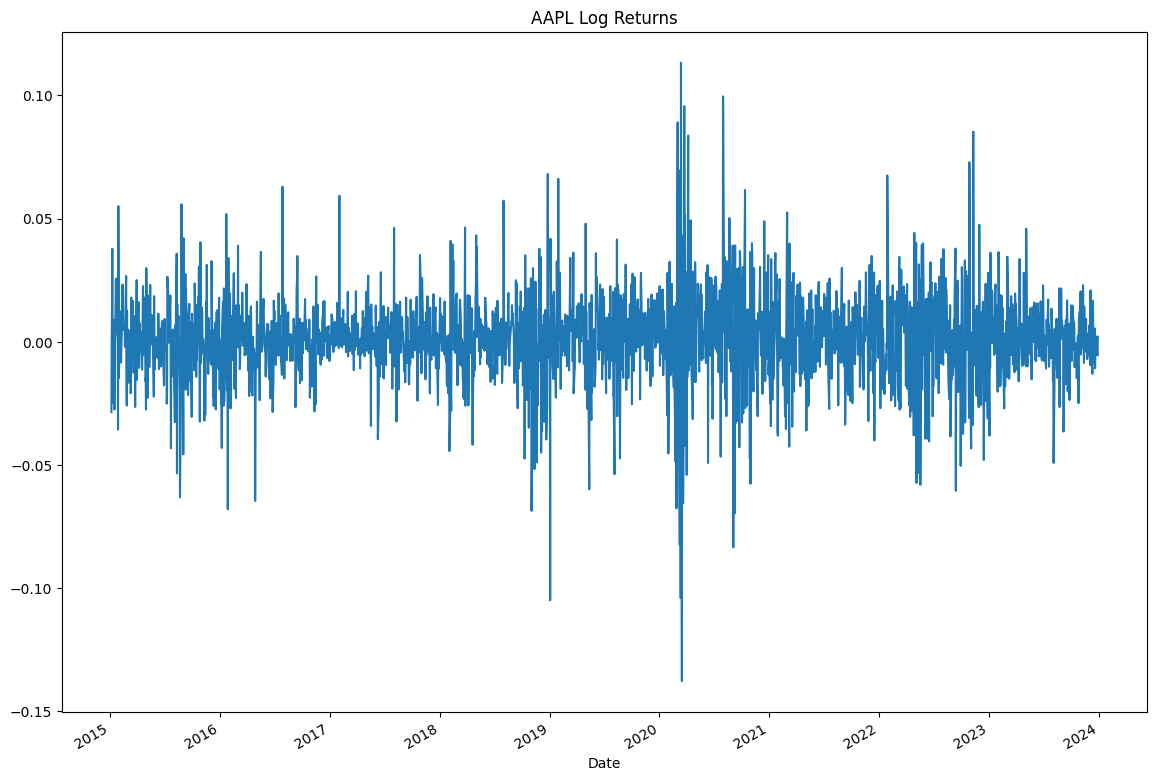

<Figure size 1400x1000 with 0 Axes>

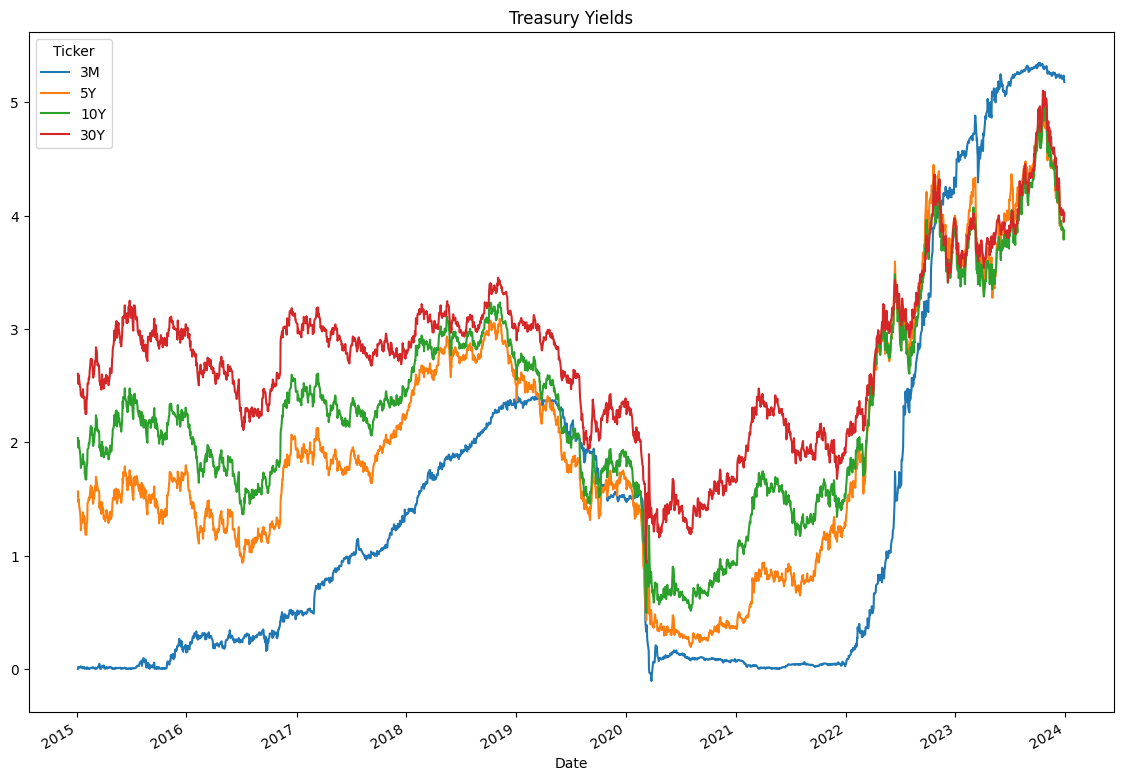

In [2]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
price = data["Close"]

returns = np.log(price / price.shift(1)).dropna()
returns = returns.rename("LogReturn") if isinstance(returns, pd.Series) else returns.rename(columns={returns.columns[0]: "LogReturn"})

treasury_tickers = ["^IRX", "^FVX", "^TNX", "^TYX"]

yields = yf.download(treasury_tickers, start=start_date, end=end_date)["Close"]
yields = yields.rename(columns={
    "^IRX": "3M",
    "^FVX": "5Y",
    "^TNX": "10Y",
    "^TYX": "30Y"
})

#merging the dataframes
features = pd.concat([returns, yields], axis=1)
features = features.ffill().dropna()

features["LogReturn"].plot(title=f"{ticker} Log Returns",figsize=(14,10))
plt.show()

plt.figure(figsize=(14,10))
features[["3M", "5Y", "10Y", "30Y"]].plot(title="Treasury Yields", figsize=(14,10))
plt.show()

In [3]:
features.head()

Ticker,LogReturn,5Y,3M,10Y,30Y
Date,,,,,
2015-01-05,-0.028576,1.568,0.003,2.039,2.605
2015-01-06,0.000094,1.493,0.020,1.963,2.523
2015-01-07,0.013925,1.473,0.020,1.954,2.515
2015-01-08,0.037702,1.496,0.018,2.016,2.593
2015-01-09,0.001072,1.443,0.015,1.971,2.556


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2263 entries, 2015-01-05 to 2023-12-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LogReturn  2263 non-null   float64
 1   5Y         2263 non-null   float64
 2   3M         2263 non-null   float64
 3   10Y        2263 non-null   float64
 4   30Y        2263 non-null   float64
dtypes: float64(5)
memory usage: 106.1 KB


### ⚙️ Module 2: Heston Model Core – Analytics & Simulation

**Objective:**  
Build two engines for option pricing under Heston:  
- Analytical engine using characteristic function  
- Simulation engine using Euler-Maruyama

**Instructions:**
1. Implement the Heston characteristic function using complex arithmetic.
2. Numerically integrate the characteristic function to compute call prices using the Fourier approach.
3. Implement the Euler-Maruyama scheme to simulate asset and volatility paths.
   - Use **full truncation** to ensure variance is non-negative.
4. Write two functions: `price_analytical(...)`, `simulate_paths(...)`.

**Hint:**  
Use `quad` for integration.To simulate variance, apply:
$$
v_{t+\Delta t} = \max\left(v_t + \kappa(\theta - v_t)\Delta t + \sigma\sqrt{v_t} \Delta W_t, 0\right)$$


In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
# -------------------------
# Correct Heston characteristic function
# -------------------------
def heston_char(u, S0, r, T, kappa, theta, sigma, rho, v0):
    """
    Characteristic function phi(u) = E[e^{i u log S_T}] for Heston (trap form).
    u : scalar (real) or complex
    """
    i = 1j
    u = np.array(u, dtype=complex)
    m = np.log(S0) + r * T  # log(S0) shifted by rT (no dividends here)
    # d (use trap-stable form)
    D = np.sqrt((rho * sigma * i * u - kappa) ** 2 + (sigma ** 2) * (i * u + u ** 2))

    # ensure stable branch: flip sign of D where Re(D) < 0 (helps numerical stability)
    if np.isscalar(D):
        if np.real(D) < 0:
            D = -D
    else:
        D = np.where(np.real(D) < 0, -D, D)

    # g (same notation as in the "little trap" paper)
    g = (kappa - rho * sigma * i * u - D) / (kappa - rho * sigma * i * u + D)

    # C and D-like terms (some authors call them A and B)
    # avoid log branch-cut issues by using the trap version with exp(-D*T)
    exp_minus_DT = np.exp(-D * T)
    # A (deterministic part)
    A = (kappa * theta) / (sigma ** 2) * ((kappa - rho * sigma * i * u - D) * T
                                         - 2.0 * np.log((1.0 - g * exp_minus_DT) / (1.0 - g)))
    # B (multiplies v0)
    B = ((kappa - rho * sigma * i * u - D) / (sigma ** 2)) * ((1.0 - exp_minus_DT) / (1.0 - g * exp_minus_DT))

    return np.exp(1j * u * m + A + B * v0)


# Analytical price using the semi-analytic Fourier integrand (numerically integrate)
def heston_price_analytical(S0, K, T, r, params,call = True, integration_limit=200):
    """
    Heston European call price (analytic via CF inversion).
    Uses the common implementation:
        price = 0.5*(S0 - K*e^{-rT}) + (1/pi) * integral_0^inf Re[ (f(u-i) - K f(u)) / (e^{i u ln K} i u ) ] du
    which is numerically stable when heston_cf is given in the trap form above.
    params : dict with keys kappa, theta, sigma, rho, v0
    integration_limit : upper limit for the integral (increase if needed)
    """
    kappa = params['kappa']
    theta = params['theta']
    sigma = params['sigma']
    rho = params['rho']
    v0 = params['v0']

    lnK = np.log(K)

    def integrand(u):
        # u is real positive integration variable
        # evaluate CF at u and u - i (complex shift)
        cf_u_minus_i = heston_char(u - 1j, S0, r, T, kappa, theta, sigma, rho, v0)
        cf_u = heston_char(u, S0, r, T, kappa, theta, sigma, rho, v0)

        numerator = cf_u_minus_i - K * cf_u
        denominator = np.exp(1j * u * lnK) * (1j * u)

        # return real part of numerator/denominator for integrand
        return np.real(numerator / denominator)

    # integrate from small epsilon to upper bound to avoid singularity at 0
    eps = 1e-8
    integral_value, _ = quad(integrand, eps, integration_limit, limit=200, epsabs=1e-8, epsrel=1e-6)

    element1 = 0.5 * (S0 - K * np.exp(-r * T))
    element2 = integral_value / np.pi

    call_price = np.real(element1 + element2)
    if call:
        return call_price
    else:
        return call_price - (S0 - K * np.exp(-r * T))

#monte carlo pricing
def heston_mc_simulation(S0, v0, T, r, params, N=20000, M=252, seed=None):
    """
    Simulate N paths with M time steps (so dt=T/M) using full-truncation Euler.
    Returns arrays S (N x (M+1)), v (N x (M+1))
    params: dict with keys kappa, theta, sigma, rho
    """
    if seed is not None:
        np.random.seed(seed)

    kappa = params['kappa']
    theta = params['theta']
    sigma = params['sigma']
    rho = params['rho']

    dt = T / M
    sqrt_dt = np.sqrt(dt)

    S = np.zeros((N, M + 1))
    v = np.zeros((N, M + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    # Cholesky matrix for correlated Brownian increments:
    # dW_v ~ N(0, dt), dW_s = rho dW_v + sqrt(1-rho^2) * dZ
    for t in range(1, M + 1):
        # generate independent normals
        z1 = np.random.normal(size=N)  # for v
        z2 = np.random.normal(size=N)  # independent for S part

        dW_v = z1 * sqrt_dt
        dW_s = (rho * z1 + np.sqrt(max(0.0, 1 - rho ** 2)) * z2) * sqrt_dt

        # Full truncation Euler: ensure v stays non-negative in diffusion term by using max(v,0)
        v_prev = v[:, t - 1]
        v_pos = np.maximum(v_prev, 0.0)

        # variance (v) Euler update (CIR like)
        dv = kappa * (theta - v_pos) * dt + sigma * np.sqrt(v_pos) * dW_v
        v_new = v_prev + dv
        # ensure non-negativity by truncating negative values to 0 (full truncation)
        v_new = np.maximum(v_new, 0.0)

        # spot S update (log-Euler or plain Euler on S). Using Euler on S
        # dS = r*S*dt + sqrt(v_pos)*S*dW_s  -> S_new = S_prev + ...
        S_prev = S[:, t - 1]
        dS = r * S_prev * dt + np.sqrt(v_pos) * S_prev * dW_s
        S_new = S_prev + dS

        S[:, t] = S_new
        v[:, t] = v_new

    return S, v

#monte carlo pricing

def heston_mc_price(S0, K, T, r, params, N=20000, M=252, call=True):
    v0 = params['v0']
    S, _ = heston_mc_simulation(S0, v0, T, r, params, N, M)
    ST = S[:, -1]
    if call:
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    return np.exp(-r * T) * np.mean(payoff)

#usage
if __name__ == "__main__":
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.01

    params = {
        'kappa': 1.5,
        'theta': 0.04,
        'sigma': 0.3,
        'rho': -0.7,
        'v0': 0.04
    }

    #Analytical heston price
    price_analytical = heston_price_analytical(S0, K, T, r, params)
    print("Heston analytical call:", price_analytical)

    #Monte carlo price
    price_sim = heston_mc_price(S0,K,T, r, params)
    print("Heston MC call:", price_sim)

Heston analytical call: 8.152967771000924
Heston MC call: 8.039171214526416


In [6]:
def bs_price(S, K, T, r, sigma, call=True):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if call:
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

### 🧮 Module 3: Unified Option Pricing Interface

**Objective:**  
Wrap all pricing engines (BSM, Heston Analytical, Heston MC) into a single interface.

**Instructions:**
1. Inherit from the Heston class and build `OptionPricer`.
2. Add BSM pricing as a fallback model.
3. Implement a method `price_option(engine='bs'|'heston'|'mc')` that dispatches to the selected method.
4. Add handling for call/put options, and print comparison tables.

**Hint:**  
You may reuse the BSM formula. Ensure consistency in inputs across engines — S, K, T, r, q, sigma/vol.


In [7]:
#unified option pricing interface
class OptionPricer:
    def __init__(self, S, K, T, r, sigma, heston_params):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.heston_params = heston_params

    def price_bs(self, call=True):
        return bs_price(self.S, self.K, self.T, self.r, self.sigma, call)

    def price_heston_analytical(self, call=True):
        return heston_price_analytical(self.S, self.K, self.T, self.r, self.heston_params, call)

    def price_heston_mc(self, call=True, N=20000, M=252):
        return heston_mc_price(self.S, self.K, self.T, self.r, self.heston_params, N, M, call)

    def price(self, engine='bs', call=True, **kwargs):
        if engine == 'bs':
            return self.price_bs(call)
        elif engine == 'heston':
            return self.price_heston_analytical(call)
        elif engine == 'mc':
            return self.price_heston_mc(call, **kwargs)
        else:
            raise ValueError("Engine not recognized: choose 'bs', 'heston', or 'mc'")


In [8]:
if __name__ == "__main__":
    S0, K, T, r, sigma = 100.0, 100.0, 1.0, 0.01, 0.2
    heston_params = {'kappa': 1.5, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7, 'v0': 0.04}

    pricer = OptionPricer(S0, K, T, r, sigma, heston_params)
    print("BSM Call:", pricer.price('bs', call=True))
    print("Heston Analytical Call:", pricer.price('heston', call=True))
    print("Heston MC Call:", pricer.price('mc', call=True, N=20000, M=252))

BSM Call: 8.433318690109608
Heston Analytical Call: 8.152967771000924
Heston MC Call: 8.088570208940578


### 📈 Module 4: MLE-Based Estimation of Heston Parameters

**Objective:**  
Fit Heston model parameters $$(\kappa, \theta, \sigma, \rho)$$ using historical return and volatility data.

**Instructions:**
1. Construct the likelihood function using discretized dynamics:
   $$\log P(r_t | v_t, \theta) \sim \text{Normal}(\mu \Delta t, \sigma \sqrt{v_t \Delta t})$$
2. Apply full truncation in the model paths.
3. Use parameter transformation to map optimization bounds (e.g., softplus or sigmoid).
4. Optimize using `scipy.optimize.minimize`.

**Hint:**  
To ensure constraints like $$\sigma > 0$$, optimize over $$ z \in \mathbb{R} $$ and map via $$\sigma = \log(1 + \exp(z))$$


In [9]:
# 📈 Module 4: MLE for Heston Parameters

from scipy.optimize import minimize

def softplus(x):
    return np.log1p(np.exp(x))

def inverse_softplus(y):
    return np.log(np.expm1(y))

def transform_params(params_transformed):
    """
    Map from unconstrained R^5 -> valid Heston parameters
    params_transformed = [kappa_z, theta_z, sigma_z, rho_z, v0_z]
    """
    kappa = softplus(params_transformed[0])   # > 0
    theta = softplus(params_transformed[1])   # > 0
    sigma = softplus(params_transformed[2])   # > 0
    rho   = np.tanh(params_transformed[3])    # (-1,1)
    v0    = softplus(params_transformed[4])   # > 0
    return kappa, theta, sigma, rho, v0

# -----------------------------
# Full truncation variance update
# -----------------------------
def simulate_variance_path(kappa, theta, sigma, v0, T, dt, returns_len, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    v = np.zeros(returns_len+1)
    v[0] = v0
    sqrt_dt = np.sqrt(dt)

    for t in range(1, returns_len+1):
        z = np.random.normal()
        v_prev = v[t-1]
        v_pos = max(v_prev, 0.0)
        dv = kappa * (theta - v_pos) * dt + sigma * np.sqrt(v_pos) * sqrt_dt * z
        v[t] = max(v_prev + dv, 0.0)   # full truncation
    return v

# -----------------------------
# Log-likelihood function
# -----------------------------
def log_likelihood(params_transformed, returns, dt, r=0.0):
    kappa, theta, sigma, rho, v0 = transform_params(params_transformed)
    T = len(returns) * dt
    
    # Simulate variance path
    v_path = simulate_variance_path(kappa, theta, sigma, v0, T, dt, len(returns))
    
    # Conditional log-likelihood
    loglik = 0.0
    for t in range(len(returns)):
        mean_rt = (r - 0.5 * v_path[t]) * dt
        var_rt = max(v_path[t], 1e-8) * dt  # avoid 0 variance
        loglik += -0.5 * (np.log(2*np.pi*var_rt) + ((returns[t]-mean_rt)**2) / var_rt)

    return -loglik  # minimize negative LL

# -----------------------------
# Example Usage
# -----------------------------
if __name__ == "__main__":
    # Suppose we have synthetic returns from a Heston path
    np.random.seed(42)
    n_steps = 252
    dt = 1/252
    returns = np.random.normal(0, 0.01, size=n_steps)  # placeholder returns

    # Initial guess in transformed space (random)
    x0 = np.random.randn(5)

    res = minimize(log_likelihood, x0, args=(returns, dt),
                   method='L-BFGS-B', options={'disp': True, 'maxiter': 200})

    # Extract estimated parameters
    kappa, theta, sigma, rho, v0 = transform_params(res.x)
    print("Estimated parameters:")
    print(f"kappa={kappa:.4f}, theta={theta:.4f}, sigma={sigma:.4f}, rho={rho:.4f}, v0={v0:.4f}")


Estimated parameters:
kappa=2.2353, theta=1.3371, sigma=0.1979, rho=-0.4496, v0=1.5151


/var/folders/nt/84lyk3v113v9t614ksvq_xlw0000gn/T/ipykernel_25130/1892420870.py:74: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(log_likelihood, x0, args=(returns, dt),


### 📊 Module 5: Real vs. Modeled Option Prices

**Objective:**  
Compare market option quotes with prices predicted by BS, Heston Analytical, and Heston Monte Carlo models.

**Instructions:**
1. Use `yfinance.Ticker(tkr).option_chain(date)` to fetch market options.
2. Match ATM/OTM calls for a given expiry.
3. Compute model prices using your pricing class.
4. Plot:
   - Market price vs. strike
   - Overlay BS, Heston, MC predictions

**Hint:**  
Focus on one expiry and one asset (e.g., `AAPL`). Label plots clearly and normalize all model prices for scale comparability.


Available expiries: ('2025-10-03', '2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-04-17', '2026-05-15', '2026-06-18', '2026-08-21', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17', '2028-01-21')
Using expiry: 2025-10-03


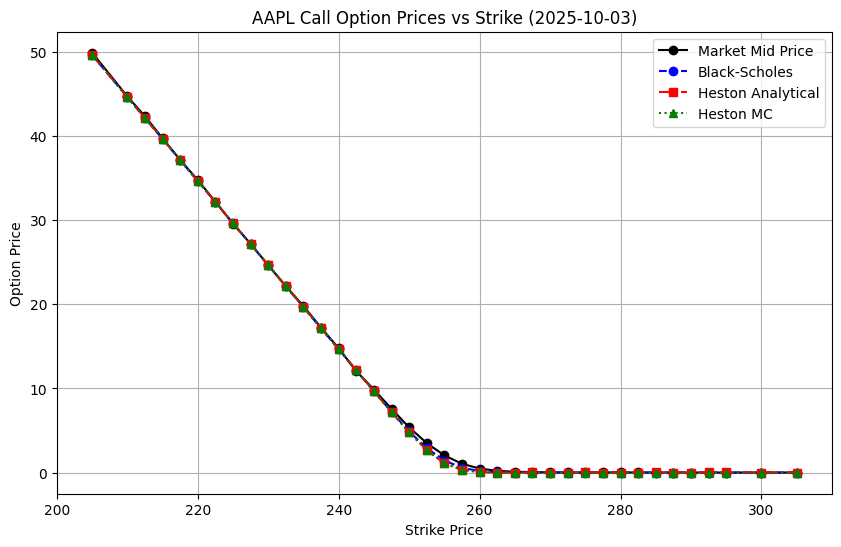

In [10]:
# 📊 Module 5: Real vs. Modeled Option Prices
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- OptionPricer should already be defined and imported ---
# from previous module: OptionPricer

ticker_symbol = "AAPL"

# --- Fetch available option expiries ---
ticker = yf.Ticker(ticker_symbol)
expiries = ticker.options
print("Available expiries:", expiries)

# Pick the nearest expiry
expiry = expiries[0]
print("Using expiry:", expiry)

# --- Fetch market option chain ---
option_chain = ticker.option_chain(expiry)
calls = option_chain.calls

# --- Fetch spot price dynamically ---
S0 = ticker.history(period="1d")['Close'].iloc[-1]
r = 0.03        # risk-free rate (annual)
sigma = 0.25    # initial vol for BS
heston_params = {
    'kappa': 1.5,
    'theta': 0.04,
    'sigma': 0.3,
    'rho': -0.7,
    'v0': 0.04
}

# --- Filter ATM/OTM calls (within +/-20% of spot) ---
atm_calls = calls[(calls['strike'] >= S0*0.8) & (calls['strike'] <= S0*1.2)]
strikes = atm_calls['strike'].values
mid_prices = (atm_calls['bid'] + atm_calls['ask']) / 2.0

# --- Time to expiry in years ---
T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 252

# --- Initialize OptionPricer ---
pricer = OptionPricer(S=S0, K=None, T=T, r=r, sigma=sigma, heston_params=heston_params)

# --- Compute model prices ---
bs_prices = []
heston_ana_prices = []
heston_mc_prices = []

for K in strikes:
    pricer.K = K
    bs_prices.append(pricer.price(engine='bs'))
    heston_ana_prices.append(pricer.price(engine='heston'))
    heston_mc_prices.append(pricer.price(engine='mc'))

bs_prices = np.array(bs_prices)
heston_ana_prices = np.array(heston_ana_prices)
heston_mc_prices = np.array(heston_mc_prices)

# --- Plotting ---
plt.figure(figsize=(10,6))
plt.plot(strikes, mid_prices, 'ko-', label='Market Mid Price')
plt.plot(strikes, bs_prices, 'b--o', label='Black-Scholes')
plt.plot(strikes, heston_ana_prices, 'r-.s', label='Heston Analytical')
plt.plot(strikes, heston_mc_prices, 'g:^', label='Heston MC')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title(f'{ticker_symbol} Call Option Prices vs Strike ({expiry})')
plt.legend()
plt.grid(True)
plt.show()